# Movie Genre Classification

Movies are a popular means of entertainment all around the world. With a lot of streaming services and websites available and with more on the horizon, building a predictive model that automatically generates the genre of a movie based on the its plot summary is definitely beneficial as it may reduce the expense of manually tagging the movies .

# Data Understanding

## Preprocessing and Exploratory Data Analysis

#### IMPORT NEEDED PACKAGES


In [32]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lilia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Information

In [33]:
# Loading the dataset
dataset_path = 'data/train_data.txt'
data = pd.read_csv(dataset_path, sep=':::', engine='python', header=None)
data.columns = ['ID', 'TITLE', 'GENRE', 'DESCRIPTION']

In [34]:
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 54214
Number of attributes = 4


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


#### Data Types

In [35]:
# Printing data types of DataFrame
data.dtypes

ID              int64
TITLE          object
GENRE          object
DESCRIPTION    object
dtype: object

#### Dataframe Statistics

In [36]:
# Printing description of DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,54214.0,27107.5,15650.378084,1.0,13554.25,27107.5,40660.75,54214.0


#           Data Cleaning and Standardization

 ### Removing HTML tags if the data is scraped from the web

In [37]:
def remove_html_tags(text):
    clean_text = re.sub(r'<[^>]+>', '', text)
    return clean_text


 ### Removing special characters

In [38]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text


 ### Removing emojis and  non-standard symbols

In [39]:
# Define a regex pattern to match emojis and non-standard symbols
# This pattern targets characters outside the typical ASCII range, which includes most emojis and non-standard symbols
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)

# Function to remove emojis and non-standard symbols
def remove_emojis_and_symbols(text):
    return emoji_pattern.sub(r'', text)

# Apply the function to remove emojis and non-standard symbols from DESCRIPTION
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols)

###   Converting to Lowercase:

In [40]:
 # Convert DESCRIPTION column to lowercase
data['DESCRIPTION'] = data['DESCRIPTION'].str.lower()


### Fixing Encoding Issues

In [41]:
try:
    data = pd.read_csv('data/train_data.txt', 
                       sep=':::', 
                       engine='python',
                       encoding='utf-8',  # Ensure UTF-8 encoding
                       on_bad_lines='skip',
                       quotechar='"', 
                       names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION']
                      )
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.


###  Remove Extra Whitespace

In [42]:
def remove_extra_whitespace(text):
    words = text.split()
    clean_words = [word.strip() for word in words]
    clean_text = ' '.join(clean_words)
    return clean_text

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(remove_extra_whitespace)


### Handle Missing Values

In [43]:
# Handle missing values
data.dropna(inplace=True)

# Check for missing values
assert not data.isnull().values.any(), "Missing values are present in the data."

# Print success message
print("Missing values handled successfully.")


Missing values handled successfully.


### Normalization

In [44]:
# Define function to normalize numbers in a column
def normalize_numbers_column(column):
    number_pattern = r'\b\d[\d,.]*\b'
    return column.str.replace(number_pattern, 'NUMBER', regex=True)

### Non-informative words

In [45]:
df = pd.DataFrame(data)
# Download the set of stop words the first time
nltk.download('stopwords')

# Load the stop words
non_informative_words = set(stopwords.words('english'))

# Define the function to remove non-informative words
def remove_non_informative(text):
    # Split the text into words and remove non-informative words
    return ' '.join(word for word in text.split() if word.lower() not in non_informative_words)

# Assuming 'df' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
# Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Summarize the checks
summary = {
    'Non-informative Words Removed': not df['contains_non_informative'].any()
}

summary


[nltk_data] Downloading package stopwords to /Users/lilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'Non-informative Words Removed': True}

### checking cleanliness

In [46]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_html_tags)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("HTML tags were present and successfully removed.")
else:
    print("No HTML tags were found in the DESCRIPTION column.")


No HTML tags were found in the DESCRIPTION column.


In [47]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_special_characters)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("Special characters were present and successfully removed.")
else:
    print("No Special characters were found in the DESCRIPTION column.")


No Special characters were found in the DESCRIPTION column.


In [48]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols
)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("emojis and symbols were present and successfully removed.")
else:
    print("No emojis and symbols were found in the DESCRIPTION column.")


No emojis and symbols were found in the DESCRIPTION column.


In [49]:
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(convert_to_lowercase)

# Check if all text is converted to lowercase
is_lowercase = (data['DESCRIPTION'].str.lower() == data['CLEAN_DESCRIPTION']).all()

if is_lowercase:
    print("All text in the CLEAN_DESCRIPTION column is in lowercase.")
else:
    print("Not all text in the CLEAN_DESCRIPTION column is in lowercase.")


All text in the CLEAN_DESCRIPTION column is in lowercase.


### Tokenization, Stop Words Removal, and Handling Negations:

In [50]:
# Tokenization, Stop Words Removal, and Handling Negations
def preprocess_text(text):
    
    # Removing non-alphanumeric characters
    # This to make sure that we do not have like (film, 's, instead we will have films)
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    
    # Tokenizing the description
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Handling negations (e.g., "not good" becomes "not_good")
    for i in range(len(filtered_tokens)):
        if filtered_tokens[i] == 'not' and i + 1 < len(filtered_tokens):
            filtered_tokens[i + 1] = 'not_' + filtered_tokens[i + 1]

    return filtered_tokens

# Applying the preprocessing function to the 'DESCRIPTION' column
data['TOKENIZED_DESCRIPTION'] = data['CLEAN_DESCRIPTION'].apply(preprocess_text)



## Summary

In [51]:
# Assuming 'data' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
df = pd.DataFrame(data)

# 1. Check for HTML tags
html_tag_pattern = re.compile(r'<[^>]+>')
df['contains_html_tags'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(html_tag_pattern.search(x)))

# 2. Check for special characters
special_chars_pattern = re.compile(r'[@#$%]')
df['contains_special_chars'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(special_chars_pattern.search(x)))

# 3. Check for non-standard symbols or emojis
non_standard_pattern = re.compile(r'[^\w\s,.!?;:\-\(\)\'\"/]')
df['contains_non_standard_symbols'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(non_standard_pattern.search(x)))

# 4. Check for lowercase text
df['is_lowercase'] = df['CLEAN_DESCRIPTION'].apply(lambda x: x.islower())

# 5 Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# 6 check for tokenization
df['is_tokenized'] = df['TOKENIZED_DESCRIPTION'].apply(lambda x: isinstance(x, list))


# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Now summarize the checks
summary = {
    'HTML Tags': df['contains_html_tags'].any(),
    'Special Characters': df['contains_special_chars'].any(),
    'Non-standard Symbols/Emojis': df['contains_non_standard_symbols'].any(),
    'Lowercase Text': not df['is_lowercase'].all(),  
    'Tokenization Applied': df['is_tokenized'].all(),
}

summary


{'HTML Tags': False,
 'Special Characters': False,
 'Non-standard Symbols/Emojis': False,
 'Lowercase Text': False,
 'Tokenization Applied': True}

In [52]:

df

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,contains_html_tags,contains_special_chars,contains_non_standard_symbols,is_lowercase,contains_non_informative,is_tokenized
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...,"[listening, conversation, doctor, parents, 10y...",False,False,False,True,False,True
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,"[brother, sister, past, incestuous, relationsh...",False,False,False,True,False,True
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,"[bus, empties, students, field, trip, museum, ...",False,False,False,True,False,True
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,"[help, unemployed, father, make, ends, meet, e...",False,False,False,True,False,True
4,5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,films title refers unrecovered bodies ground z...,"[films, title, refers, unrecovered, bodies, gr...",False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This shortlived NBC live sitcom centered on B...,shortlived nbc live sitcom centered bonino wor...,"[shortlived, nbc, live, sitcom, centered, boni...",False,False,False,True,False,True
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION The siste...,next generation exploitation sisters kapa bay ...,"[next, generation, exploitation, sisters, kapa...",False,False,False,True,False,True
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,Ze bestaan echt is a standup comedy about gro...,ze bestaan echt standup comedy growing facing ...,"[ze, bestaan, echt, standup, comedy, growing, ...",False,False,False,True,False,True
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...,"[walter, vivian, live, country, difficult, tim...",False,False,False,True,False,True


## TEXT REPRESENTATION

### TF - IDF : Term Frequency-Inverse Document Frequency

***In this code:***

We join the tokenized words back into sentences because TfidfVectorizer expects an iterable of strings as input.

We initialize the TfidfVectorizer and fit it on the processed descriptions to learn the vocabulary and compute the IDF values.

We transform the processed descriptions into TF-IDF features.

Finally, we convert the TF-IDF features into a DataFrame for further analysis.

In [53]:
# Words to exclude
exclude_words = ['first', 'three', 'us', 'get','one','two']

# Join the tokenized words back into sentences
data['processed_description'] = data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(max_features=5000,stop_words=exclude_words)

# Fit and transform the processed descriptions to get TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_description'])

# Convert the TF-IDF features into a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, tfidf_df contains TF-IDF features for each movie description
# You can concatenate this DataFrame with your original data if needed
print(tfidf_df)


        10  100  1000  10000        11   12   13   14   15   16  ...  \
0      0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
1      0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
2      0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
3      0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
4      0.0  0.0   0.0    0.0  0.169139  0.0  0.0  0.0  0.0  0.0  ...   
...    ...  ...   ...    ...       ...  ...  ...  ...  ...  ...  ...   
54209  0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
54210  0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
54211  0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
54212  0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
54213  0.0  0.0   0.0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   

       youngsters  youre  youth  youtube  youve  zealand  zombie  zombies  \
0             0.0    0.0    0.0      0.0    0.0      0.0  

In [54]:
data.head(5)

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,processed_description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening in to a conversation between his do...,"[listening, conversation, doctor, parents, 10y...",listening conversation doctor parents 10yearol...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,a brother and sister with a past incestuous r...,"[brother, sister, past, incestuous, relationsh...",brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,as the bus empties the students for their fie...,"[bus, empties, students, field, trip, museum, ...",bus empties students field trip museum natural...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,to help their unemployed father make ends mee...,"[help, unemployed, father, make, ends, meet, e...",help unemployed father make ends meet edith tw...
4,5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,the films title refers not only to the unreco...,"[films, title, refers, unrecovered, bodies, gr...",films title refers unrecovered bodies ground z...


### PLOT THE TOP WORDS FOR EACH GENRE

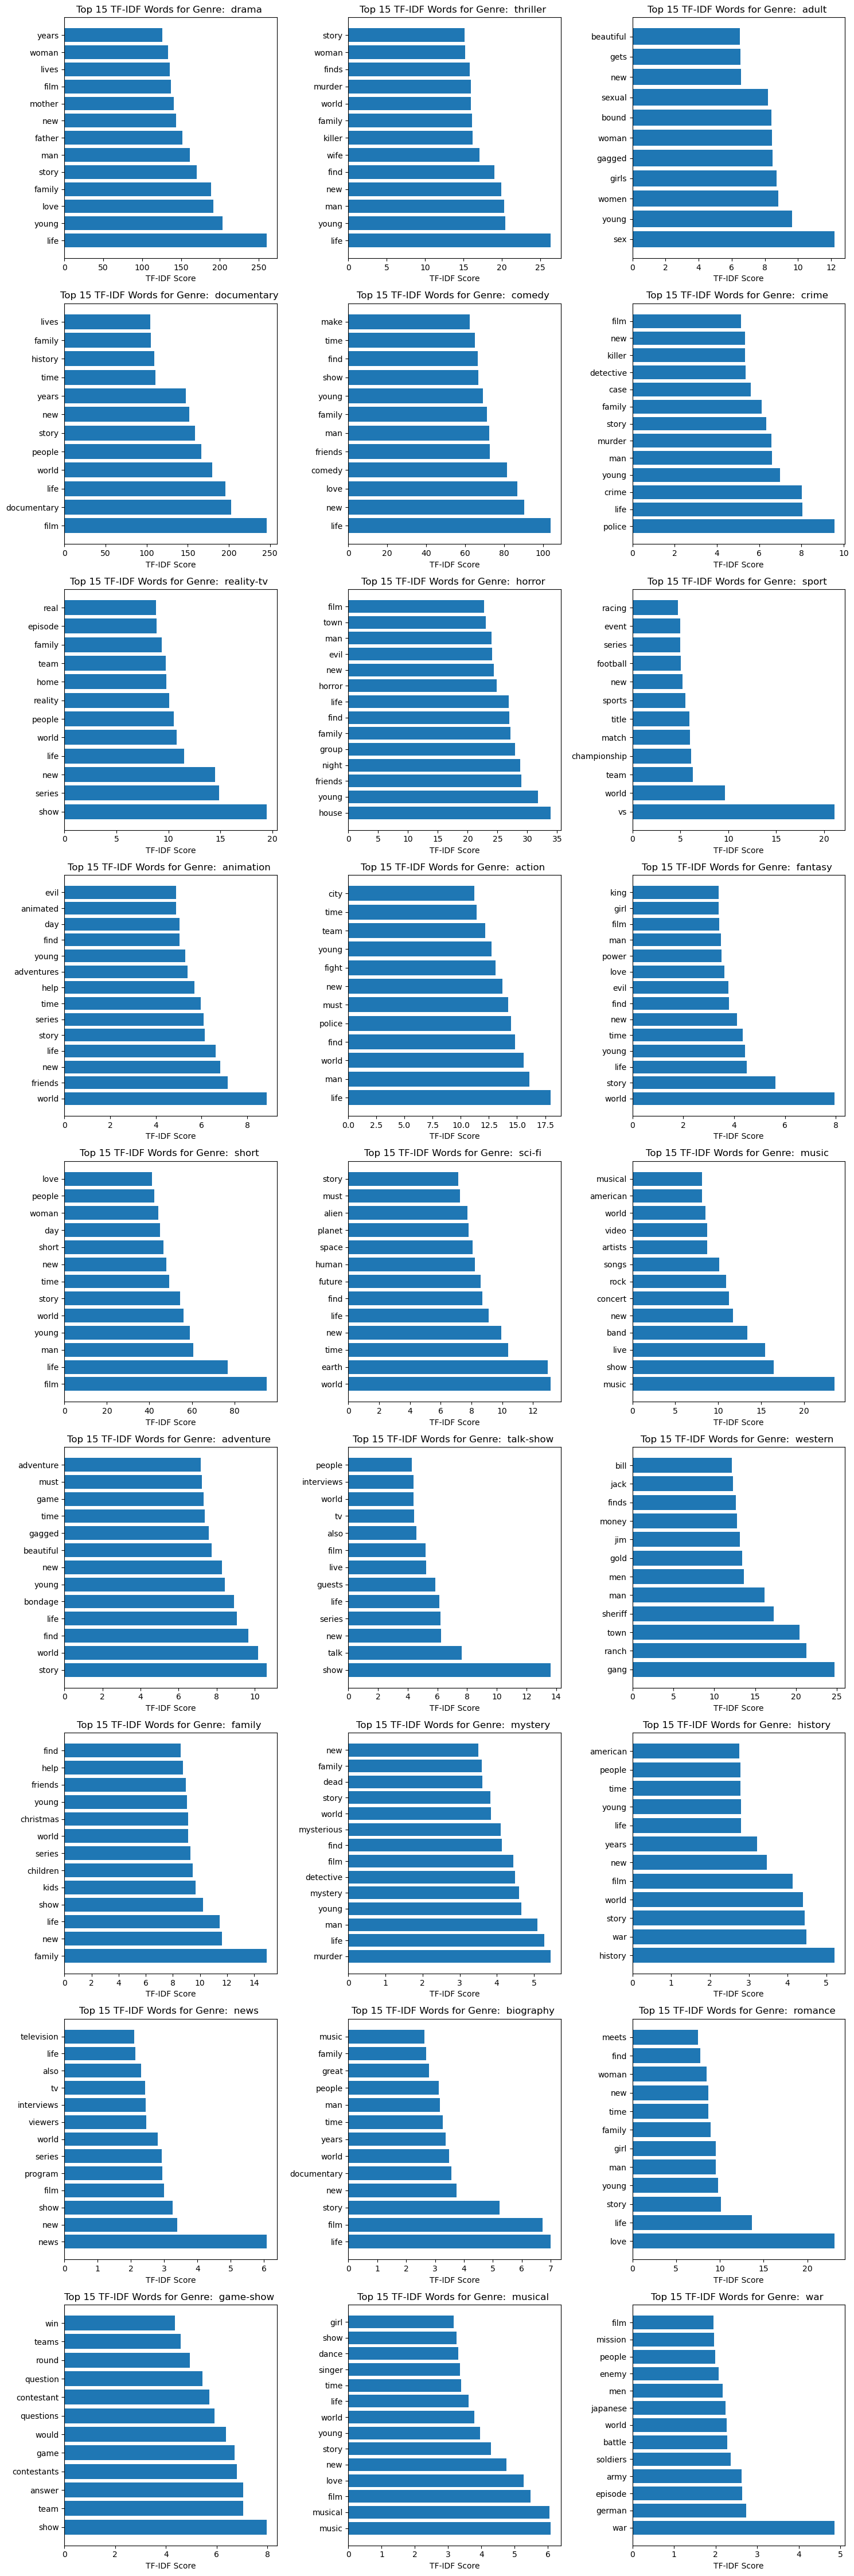

In [55]:

# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store TF-IDF scores for each genre
genre_tfidf = {}

# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Fit and transform description for the current genre
    tfidf_features = tfidf_vectorizer.fit_transform(genre_data['processed_description'])
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each feature across all documents
    tfidf_scores = tfidf_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and TF-IDF scores as values
    genre_tfidf[genre] = dict(zip(feature_names, tfidf_scores))
    
    # Get top 15 words and their TF-IDF scores for the current genre
    top_words = sorted(genre_tfidf[genre].items(), key=lambda x: x[1], reverse=True)[:15]
    words, scores = zip(*top_words)
    
    # Remove excluded words
    words = [word for word in words if word not in exclude_words]
    scores = [score for word, score in top_words if word not in exclude_words]
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), scores, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('TF-IDF Score')
    ax.set_title(f'Top 15 TF-IDF Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()
    
   

### APPLY THE BAG OF WORDS ON THE DATA:

In [56]:
# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store Bag of Words counts for each genre
genre_bow = {}

# Iterate over each genre
for genre in genres:
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Join the tokenized words back into sentences
    genre_data['processed_description2'] = genre_data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
    
    # Initialize the CountVectorizer with excluded words
    count_vectorizer = CountVectorizer(stop_words=exclude_words)
    
    # Fit and transform the processed descriptions to get Bag of Words features
    bow_features = count_vectorizer.fit_transform(genre_data['processed_description2'])
    
    # Get feature names
    feature_names = count_vectorizer.get_feature_names_out()
    
    # Sum the Bag of Words counts for each feature across all documents
    bow_counts = bow_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and Bag of Words counts as values
    genre_bow[genre] = dict(zip(feature_names, bow_counts))

# Now, genre_bow contains Bag of Words counts for each genre
# You can use this dictionary for plotting or further analysis

/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4268/231382449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4268/231382449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/i

/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4268/231382449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4268/231382449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['TOKENIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/i

## PLOT THE TOP WORDS FOR EACH GENRE

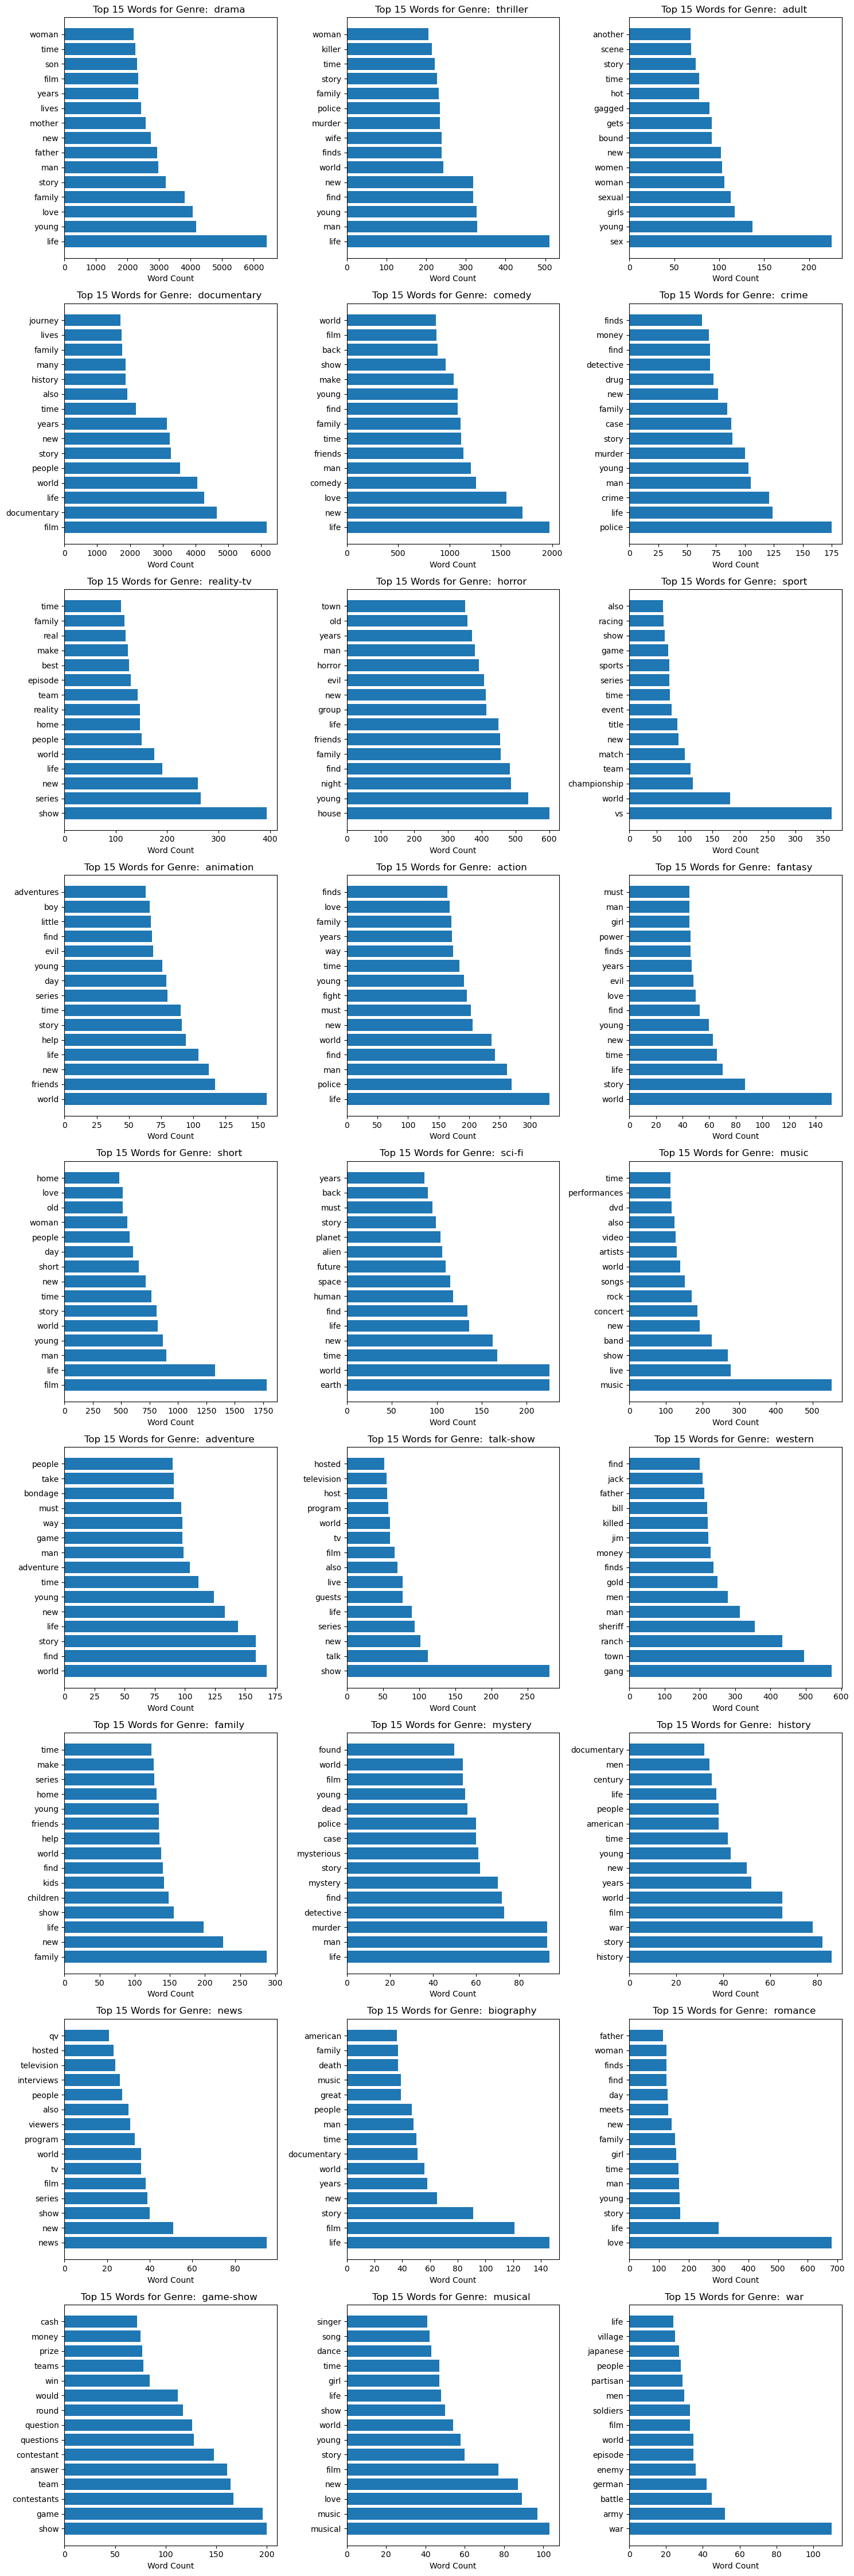

In [57]:
# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Get Bag of Words counts for the current genre
    bow_counts = genre_bow[genre]
    
    # Sort the dictionary by value (word counts)
    sorted_bow_counts = sorted(bow_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Get top 15 words and their counts for the current genre
    top_words = sorted_bow_counts[:15]
    words, counts = zip(*top_words)
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), counts, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('Word Count')
    ax.set_title(f'Top 15 Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

